In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
from pytt.utils import read_pickle
from utils import precision_recall_f1
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.metrics import ndcg_score
import numpy as np
from torch import tensor # TODO: take out when bug fixed

In [2]:
import copy
# mode should be 'percentage', 'ranking', or 'attention'
def get_scores(row, mode='percentage'):
    if mode == 'ranking' or mode == 'percentage':
        reference_sentence_rankings = np.array(list(range(row.num_report_clusters)))
        if mode == 'percentage':
            reference_sentence_rankings = reference_sentence_rankings/row.num_report_clusters
        return (-reference_sentence_rankings).tolist()
    elif mode == 'attention':
        return eval(row.sentence_attention)
    else:
        raise Exception

def get_curve_args(df, mode='percentage'):
    sentence_rankings, sentence_labels = [], []
    for i,row in df.iterrows():
        num_report_clusters = row.num_report_clusters
        sentence_rankings_temp = list(range(num_report_clusters))
        reference_sentence_rankings = set(eval(row.reference_sentence_rankings))
        sentence_labels_temp = [(i in reference_sentence_rankings) for i in sentence_rankings_temp]
        sentence_rankings += get_scores(row, mode=mode)
        sentence_labels += sentence_labels_temp
    print(sum(sentence_labels)/len(sentence_labels))
    return np.array(sentence_labels, dtype=np.float), np.array(sentence_rankings, dtype=np.float)

def get_reference_scores(df, mode='percentage'):
    scores = []
    for i,row in df.iterrows():
        scores_temp = get_scores(row, mode=mode)
        scores += [scores_temp[i] for i in eval(row.reference_sentence_rankings)]
    return scores

def plot_rankings(rankings):
    plt.hist(rankings, bins=20)
#     plt.axis([0, 1, 0, 300])

def make_plots(dfs, plot_directory, mode='percentage'):
    rankings = {model:get_reference_scores(df, mode=mode) for model,df in dfs.items()}
    roc_curves = {model:roc_curve(*get_curve_args(df, mode=mode)) for model,df in dfs.items()}
    roc_auc = {model:roc_auc_score(*get_curve_args(df, mode=mode)) for model,df in dfs.items()}
    precision_recall_curves = {model:precision_recall_curve(*get_curve_args(df, mode=mode)) for model,df in dfs.items()}
    average_precision = {model:average_precision_score(*get_curve_args(df, mode=mode)) for model,df in dfs.items()}
    for model,mrankings in rankings.items():
        print(model)
        plot_rankings(mrankings)
        plt.savefig(os.path.join(plot_directory, 'rankings_distribution_%s.eps' % model))
        plt.show()
    print("roc_auc:")
    print(roc_auc)
    print("average_precision:")
    print(average_precision)
    fig, axs = plt.subplots(1, 2, figsize=(10,4))
    for model,(fpr, tpr, thresholds) in roc_curves.items():
        line, = axs[0].plot(fpr, tpr)
        line.set_label(model)
        axs[0].legend()
    #     plt.show()
    # plt.plot([0,1],[0,1])
    axs[0].axis([0,1,0,1])
#     plt.title("ROC")
    axs[0].set_xlabel("1-Specificity", fontsize='large')
    axs[0].set_ylabel("Sensitivity/Recall", fontsize='large')
#     plt.savefig(os.path.join(plot_directory, 'roc_curve.eps'))
#     plt.show()
    for model,(p, r, thresholds) in precision_recall_curves.items():
        line, = axs[1].plot(r, p)
        line.set_label(model)
        axs[1].legend()
    #     plt.show()
    axs[1].axis([0,1,0,.3])
#     plt.title("Precision Recall Curve")
    axs[1].set_xlabel("Sensitivity/Recall", fontsize='large')
    axs[1].set_ylabel("Precision", fontsize='large')
#     plt.savefig(os.path.join(plot_directory, 'precision_recall_curve.eps'))
#     plt.show()
    plt.savefig(os.path.join(plot_directory, 'roc_prc.eps'))
    plt.show()
    return roc_auc, average_precision

def limit_summary_sentences(df, summary_sentences):
    newdf = []
    for i,row in df.iterrows():
        if (row.timepoint_id, row.code_name) not in summary_sentences.keys(): continue
        sentences = summary_sentences[(row.timepoint_id, row.code_name)]
        newrow = copy.deepcopy(row)
        orsis, orsrs = eval(row.reference_sentence_indices), eval(row.reference_sentence_rankings)
        newrow.reference_sentence_rankings = str([orsrs[i] for i in sentences])
        newdf.append(newrow)
    return pd.DataFrame(newdf)

def f1(p, r):
    return 2*p*r/(p+r)

def avg_ndcg(df):
    scores = []
    for i,row in df.iterrows():
        sentence_scores = get_scores(row, mode='ranking')
        num_report_clusters = row.num_report_clusters
        sentence_rankings_temp = list(range(num_report_clusters))
        reference_sentence_rankings = set(eval(row.reference_sentence_rankings))
        sentence_labels = [1 if (i in reference_sentence_rankings) else 0 for i in sentence_rankings_temp]
        score = ndcg_score(np.asarray([sentence_labels]), np.asarray([sentence_scores]))
        scores.append(score)
    return sum(scores)/len(scores)


In [16]:
models = ['tfidf', 'cosine', 'indicator', 'description', 'hierarchy']
base_path = "/Users/jeredmcinerney/Desktop/supervised_results/%s.csv"
# models = ['500', '1000', ]
# base_path = "/Users/jeredmcinerney/Desktop/stats_progression/summary_stats%s.csv"
dfs = {model:pd.read_csv(base_path % model) for model in models}
# print(dfs['tfidf'])
tfidf_zero_summary_sentences = {
    (r.timepoint_id, r.code_name):
        [i for i,rsr in enumerate(eval(r.reference_sentence_rankings)) if eval(r.sentence_attention)[rsr] == 0]
    for _,r in dfs['tfidf'].iterrows()}
tfidf_nonzero_summary_sentences = {
    (r.timepoint_id, r.code_name):
        [i for i,rsr in enumerate(eval(r.reference_sentence_rankings)) if eval(r.sentence_attention)[rsr] != 0]
    for _,r in dfs['tfidf'].iterrows()}
dfs_tfidf_zero = {m:limit_summary_sentences(df, tfidf_zero_summary_sentences) for m,df in dfs.items()}
dfs_tfidf_nonzero = {m:limit_summary_sentences(df, tfidf_nonzero_summary_sentences) for m,df in dfs.items()}

     Unnamed: 0           code_name  code_idx  attention_entropy  \
0             0             179-189      3128                NaN   
1             1             410-414      3232       3.293530e+00   
2             2            Neoplasm      3306                NaN   
3             3             430-438      3236       2.244892e+00   
4             4            custom15      3316       3.865694e+00   
5             5            custom17      3318       2.701528e+00   
6             6                 185      3134       2.509645e+00   
7             7            Vascular      3309       1.098612e+00   
8             0             179-189      3128                NaN   
9             1            Neoplasm      3306                NaN   
10            0                 432      3238       6.567982e-01   
11            1             custom2      3321       3.082079e+00   
12            2             430-438      3236       3.049396e+00   
13            3               432.1      3240   

In [18]:
len([x for k,v in tfidf_nonzero_summary_sentences.items() for x in v]), len([x for k,v in tfidf_zero_summary_sentences.items() for x in v])
# tfidf_zero_summary_sentences


(361, 1479)

0.0204548064775468
0.019858929286636108
0.022022862103892347
0.019858929286636108
0.019858929286636108
0.0204548064775468
0.019858929286636108
0.022022862103892347
0.019858929286636108
0.019858929286636108
0.0204548064775468
0.019858929286636108
0.022022862103892347
0.019858929286636108
0.019858929286636108
0.0204548064775468
0.019858929286636108
0.022022862103892347
0.019858929286636108
0.019858929286636108
tfidf


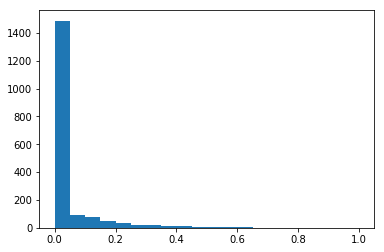

cosine


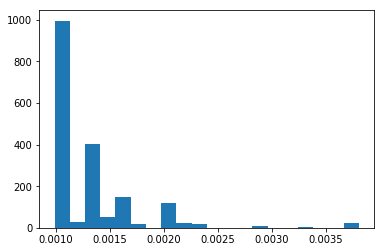

indicator


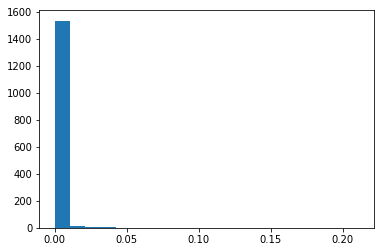

description


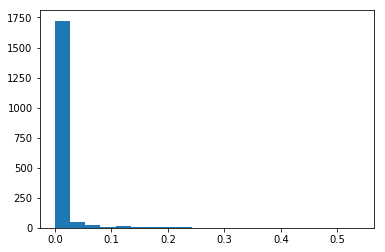

hierarchy


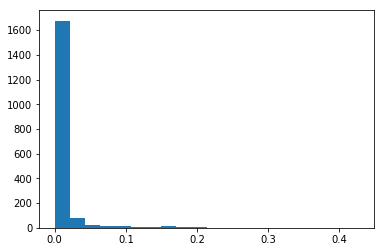

roc_auc:
{'tfidf': 0.587822739015254, 'cosine': 0.5692890061960152, 'indicator': 0.523250920958296, 'description': 0.684278823959918, 'hierarchy': 0.6787154271917736}
average_precision:
{'tfidf': 0.06051425789857474, 'cosine': 0.02514512453872795, 'indicator': 0.03788683083624068, 'description': 0.11626578270197419, 'hierarchy': 0.10982315659643829}


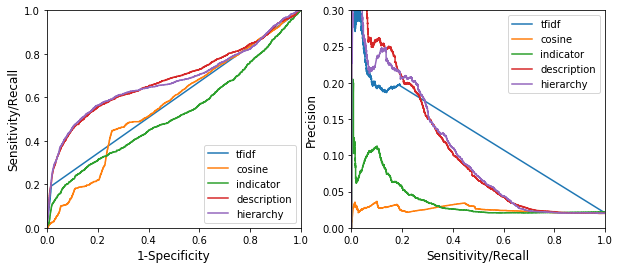

0.0204548064775468
0.019858929286636108
0.022022862103892347
0.019858929286636108
0.019858929286636108
0.0204548064775468
0.019858929286636108
0.022022862103892347
0.019858929286636108
0.019858929286636108
0.0204548064775468
0.019858929286636108
0.022022862103892347
0.019858929286636108
0.019858929286636108
0.0204548064775468
0.019858929286636108
0.022022862103892347
0.019858929286636108
0.019858929286636108
tfidf


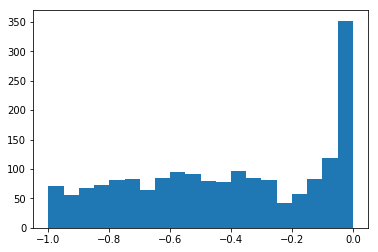

cosine


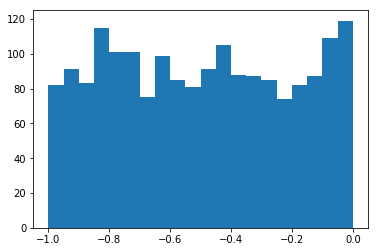

indicator


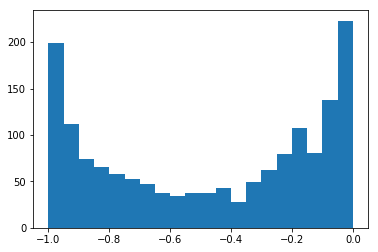

description


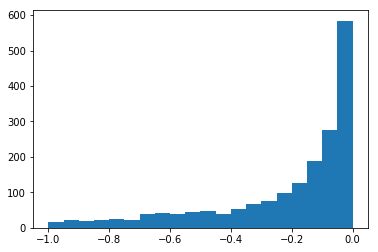

hierarchy


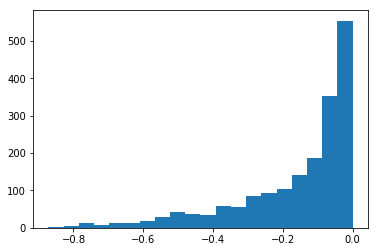

roc_auc:
{'tfidf': 0.5783307063478311, 'cosine': 0.5078940285634226, 'indicator': 0.5313296863496284, 'description': 0.7824393572001043, 'hierarchy': 0.8418411353690047}
average_precision:
{'tfidf': 0.045307396005508205, 'cosine': 0.021360615158939868, 'indicator': 0.0359905788794001, 'description': 0.0927947288498645, 'hierarchy': 0.10639394081848295}


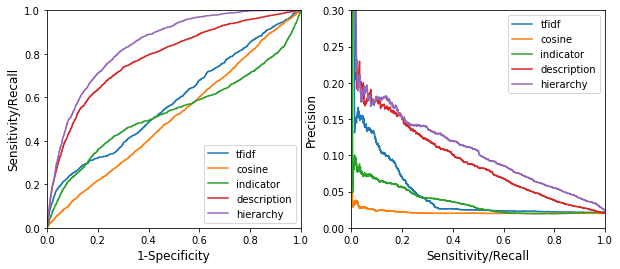

0.0204548064775468
0.019858929286636108
0.022022862103892347
0.019858929286636108
0.019858929286636108
0.0204548064775468
0.019858929286636108
0.022022862103892347
0.019858929286636108
0.019858929286636108
0.0204548064775468
0.019858929286636108
0.022022862103892347
0.019858929286636108
0.019858929286636108
0.0204548064775468
0.019858929286636108
0.022022862103892347
0.019858929286636108
0.019858929286636108
tfidf


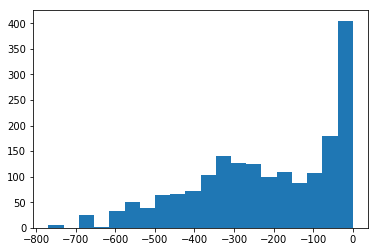

cosine


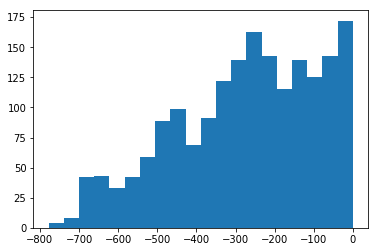

indicator


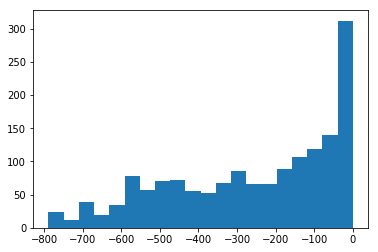

description


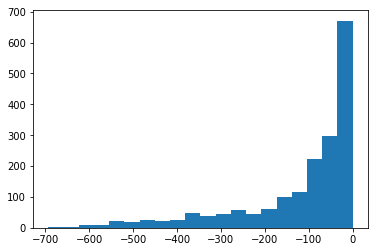

hierarchy


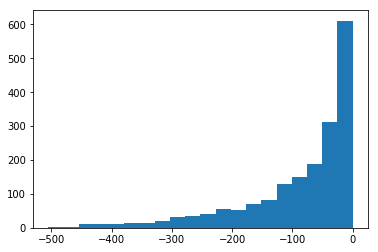

roc_auc:
{'tfidf': 0.6097464544846495, 'cosine': 0.5448220128469554, 'indicator': 0.5791220879352732, 'description': 0.7946838009429359, 'hierarchy': 0.8469789191514016}
average_precision:
{'tfidf': 0.046728693449499925, 'cosine': 0.023031023738612055, 'indicator': 0.03988456557598566, 'description': 0.09625465646193612, 'hierarchy': 0.11053912324868848}


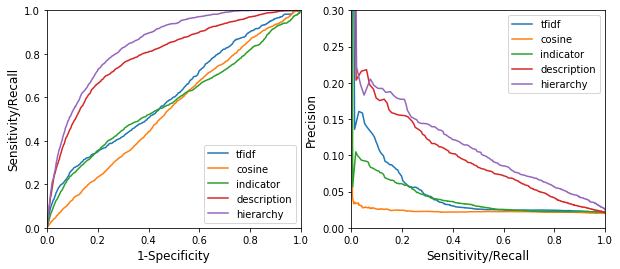

({'cosine': 0.5448220128469554,
  'description': 0.7946838009429359,
  'hierarchy': 0.8469789191514016,
  'indicator': 0.5791220879352732,
  'tfidf': 0.6097464544846495},
 {'cosine': 0.023031023738612055,
  'description': 0.09625465646193612,
  'hierarchy': 0.11053912324868848,
  'indicator': 0.03988456557598566,
  'tfidf': 0.046728693449499925})

In [5]:
make_plots(dfs, '/Users/jeredmcinerney/Desktop/plots_attention', mode='attention')
make_plots(dfs, '/Users/jeredmcinerney/Desktop/plots_percentage', mode='percentage')
make_plots(dfs, '/Users/jeredmcinerney/Desktop/plots_ranking', mode='ranking')

In [6]:
# make_plots(dfs_tfidf_nonzero, '/Users/jeredmcinerney/Desktop/plots', mode='attention')

0.01652693235327897
0.016054025188020116
0.01865142526407177
0.016054025188020116
0.016054025188020116
0.01652693235327897
0.016054025188020116
0.01865142526407177
0.016054025188020116
0.016054025188020116
0.01652693235327897
0.016054025188020116
0.01865142526407177
0.016054025188020116
0.016054025188020116
0.01652693235327897
0.016054025188020116
0.01865142526407177
0.016054025188020116
0.016054025188020116
tfidf


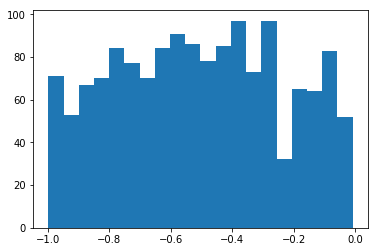

cosine


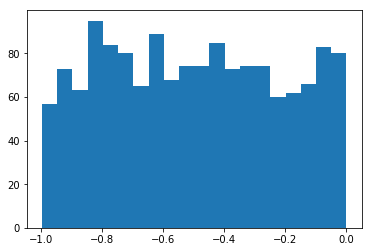

indicator


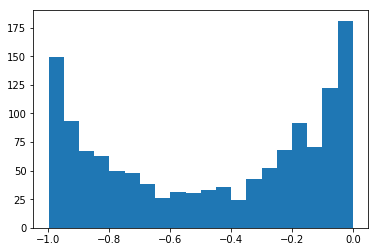

description


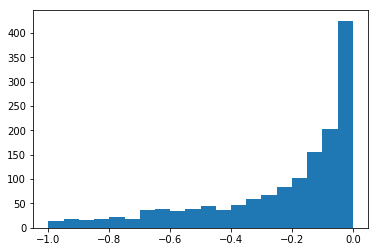

hierarchy


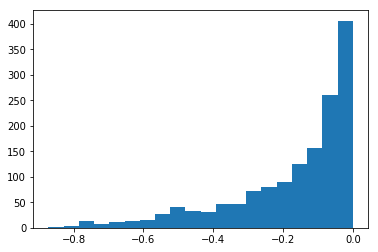

roc_auc:
{'tfidf': 0.48197022197372247, 'cosine': 0.5004316865953438, 'indicator': 0.5341624130393257, 'description': 0.7632883398082797, 'hierarchy': 0.8275659073309485}
average_precision:
{'tfidf': 0.015004864293818409, 'cosine': 0.016138650601884044, 'indicator': 0.030036158927475843, 'description': 0.06678747672004191, 'hierarchy': 0.07549425634125446}


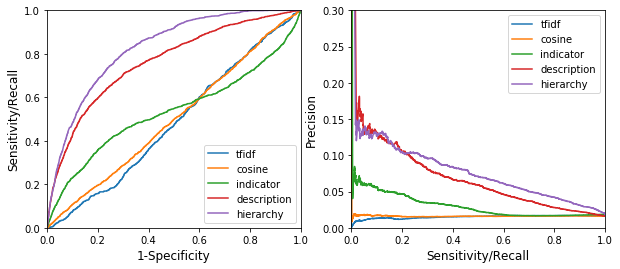

({'cosine': 0.5004316865953438,
  'description': 0.7632883398082797,
  'hierarchy': 0.8275659073309485,
  'indicator': 0.5341624130393257,
  'tfidf': 0.48197022197372247},
 {'cosine': 0.016138650601884044,
  'description': 0.06678747672004191,
  'hierarchy': 0.07549425634125446,
  'indicator': 0.030036158927475843,
  'tfidf': 0.015004864293818409})

In [19]:
make_plots(dfs_tfidf_zero, '/Users/jeredmcinerney/Desktop/plots')

tfidf


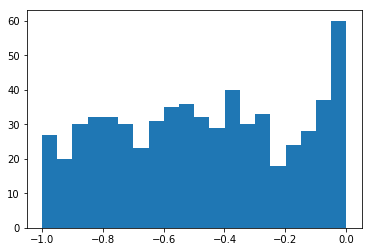

cosine


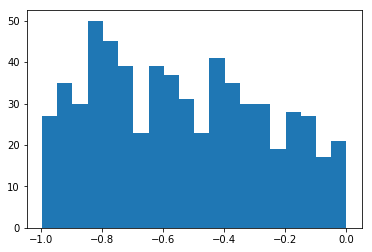

indicator


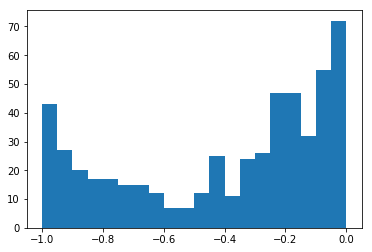

description


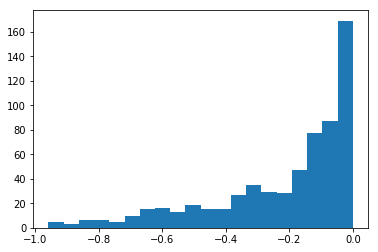

hierarchy


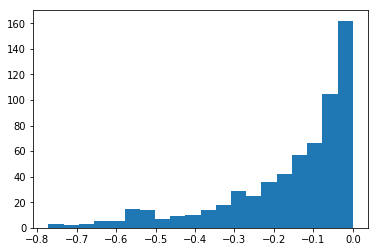

roc_auc:
{'tfidf': 0.5208552822740848, 'cosine': 0.4602839073384833, 'indicator': 0.6022543660890087, 'description': 0.7810734455802817, 'hierarchy': 0.840958730979853}
average_precision:
{'tfidf': 0.0258274154222539, 'cosine': 0.017148368653311402, 'indicator': 0.042372890071106714, 'description': 0.07922438679562452, 'hierarchy': 0.09500247435596852}


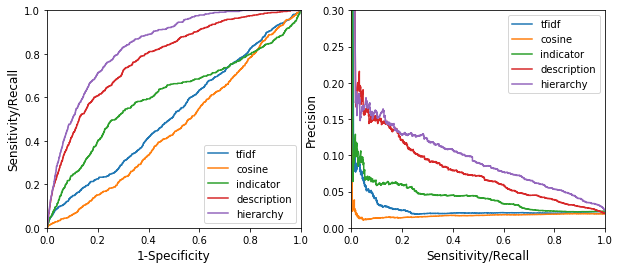

tfidf


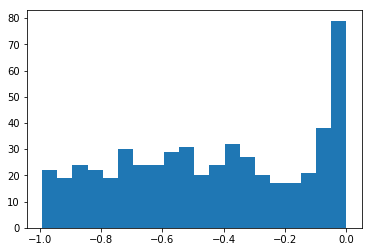

cosine


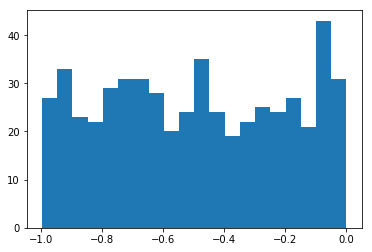

indicator


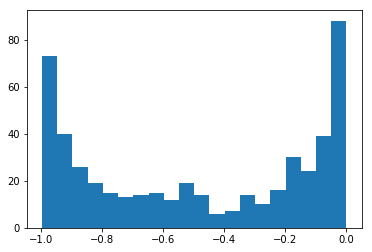

description


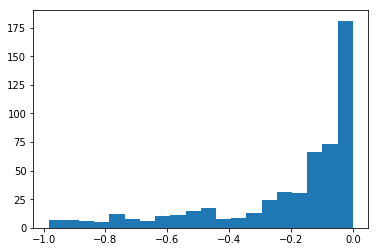

hierarchy


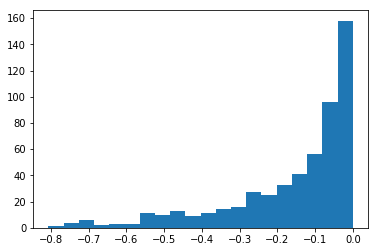

roc_auc:
{'tfidf': 0.5538906727569128, 'cosine': 0.5048670766081109, 'indicator': 0.5185167477978674, 'description': 0.7852631865082481, 'hierarchy': 0.8425739123560625}
average_precision:
{'tfidf': 0.03297836371283157, 'cosine': 0.019178666594124365, 'indicator': 0.04156050740289469, 'description': 0.08945601786342068, 'hierarchy': 0.10054496497335016}


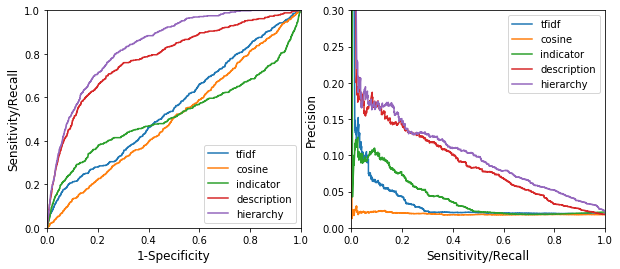

tfidf


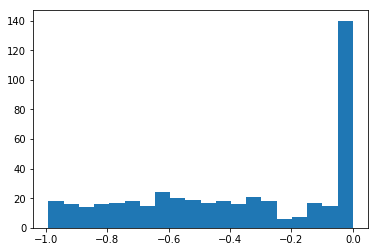

cosine


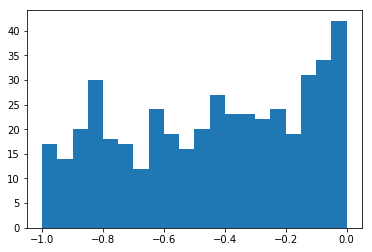

indicator


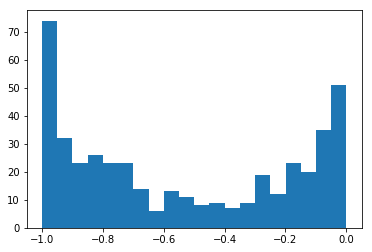

description


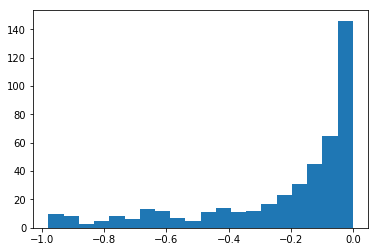

hierarchy


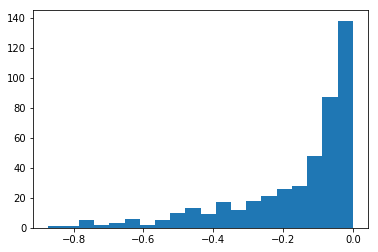

roc_auc:
{'tfidf': 0.6162545075474082, 'cosine': 0.5628256718534804, 'indicator': 0.4595334399373049, 'description': 0.7735272210923073, 'hierarchy': 0.8390990084674389}
average_precision:
{'tfidf': 0.08782735283762026, 'cosine': 0.029945587268348596, 'indicator': 0.028844614913328386, 'description': 0.10706422899816145, 'hierarchy': 0.12190252384121192}


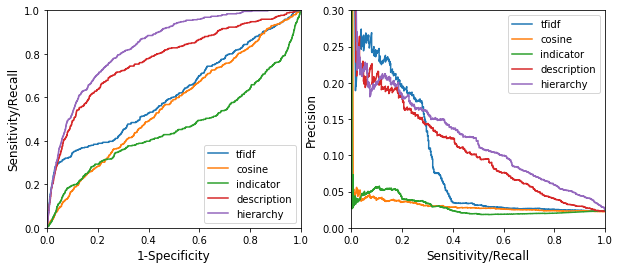

tfidf


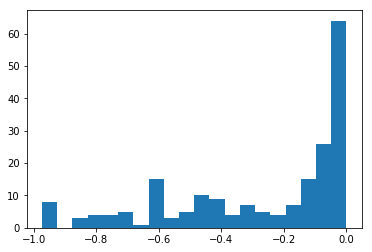

cosine


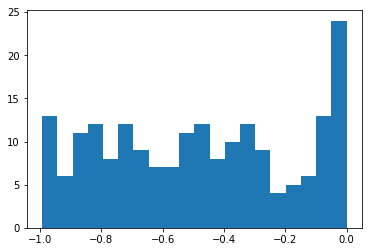

indicator


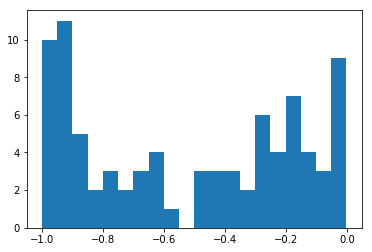

description


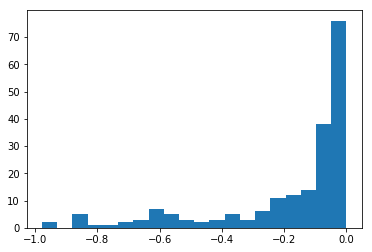

hierarchy


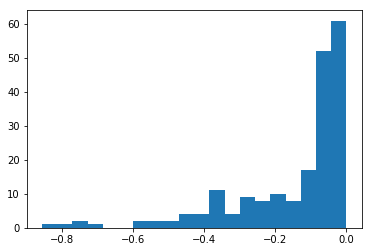

roc_auc:
{'tfidf': 0.7252741400614868, 'cosine': 0.5285843145291501, 'indicator': 0.49320244601861485, 'description': 0.81531744479221, 'hierarchy': 0.856023486598604}
average_precision:
{'tfidf': 0.12689462812101956, 'cosine': 0.03779902522279903, 'indicator': 0.02758163386205401, 'description': 0.1635147599246977, 'hierarchy': 0.17117670286648384}


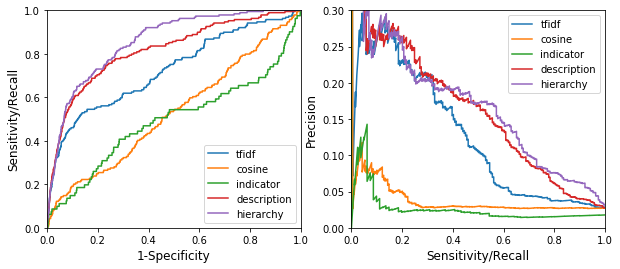

tfidf


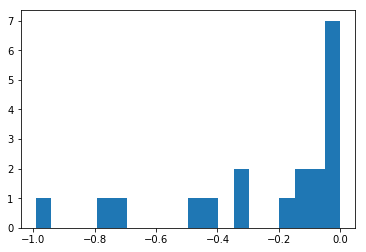

cosine


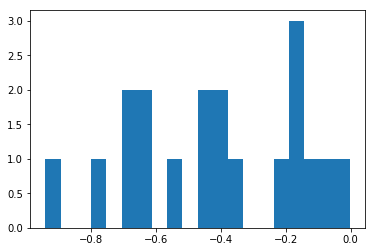

indicator


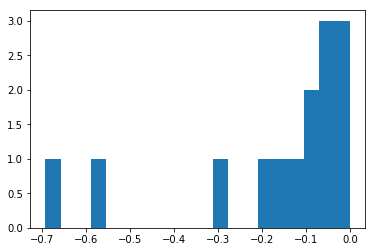

description


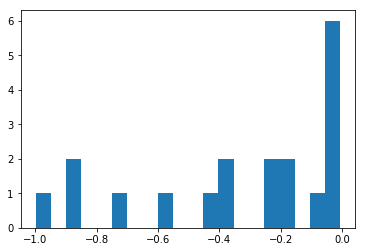

hierarchy


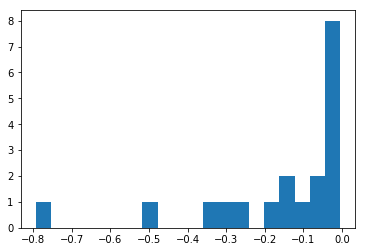

roc_auc:
{'tfidf': 0.7562535637256117, 'cosine': 0.5801517523786583, 'indicator': 0.8302783282291479, 'description': 0.6752017343128989, 'hierarchy': 0.8421052631578947}
average_precision:
{'tfidf': 0.1116741304248427, 'cosine': 0.016819019968203966, 'indicator': 0.06210940906901062, 'description': 0.04226141964697176, 'hierarchy': 0.06107011778666327}


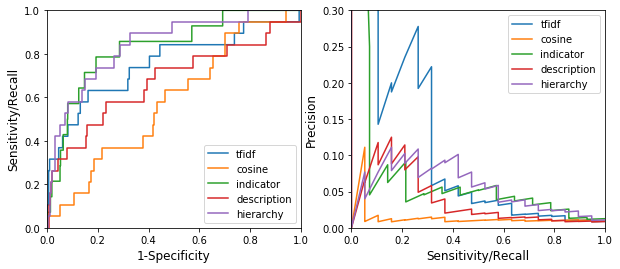

tfidf


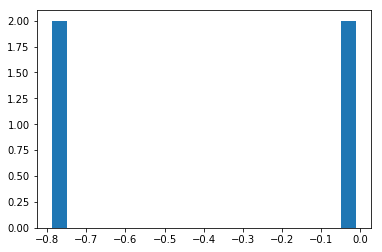

cosine


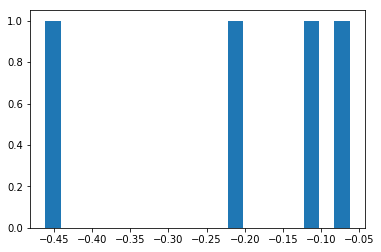

indicator


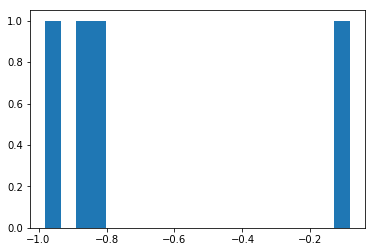

description


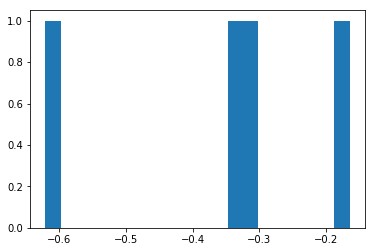

hierarchy


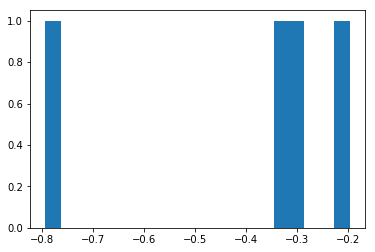

roc_auc:
{'tfidf': 0.6058201058201058, 'cosine': 0.7871536523929472, 'indicator': 0.30604534005037787, 'description': 0.6404282115869018, 'hierarchy': 0.5969773299748111}
average_precision:
{'tfidf': 0.10590641398748826, 'cosine': 0.03419462725213076, 'indicator': 0.013322184045155696, 'description': 0.0171270267368195, 'hierarchy': 0.01613031543712192}


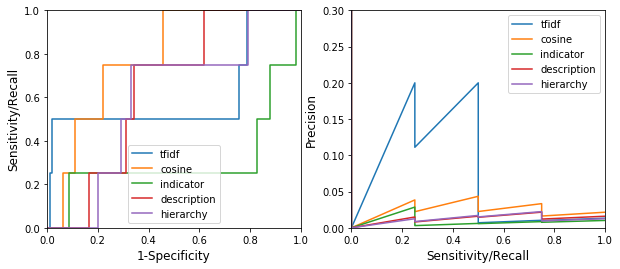

In [8]:
roc_auc = {model:[] for model in dfs.keys()}
average_precision = {model:[] for model in dfs.keys()}
for i in range(1,dfs['tfidf'].depth.max()+1):
    dfsi = {model:df[df.depth == i] for model,df in dfs.items()}
    roc_auc_temps, average_precision_temps = make_plots(dfsi, '/Users/jeredmcinerney/Desktop/plots')
    for model,roc_auc_temp in roc_auc_temps.items():
        roc_auc[model].append(roc_auc_temp)
    for model,average_precision_temp in average_precision_temps.items():
        average_precision[model].append(average_precision_temp)

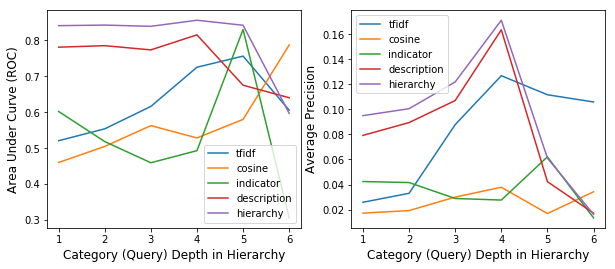

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))
plot_directory = "/Users/jeredmcinerney/Desktop/plots"
for model,roc_auc_scores in roc_auc.items():
    line, = axs[0].plot(np.array(range(len(roc_auc_scores)))+1,roc_auc_scores)
    line.set_label(model)
axs[0].legend()
axs[0].set_xlabel("Category (Query) Depth in Hierarchy", fontsize='large')
axs[0].set_ylabel("Area Under Curve (ROC)", fontsize='large')
# plt.savefig(os.path.join(plot_directory, 'rocauc_by_depth.png'))
# plt.show()
for model,average_precision_scores in average_precision.items():
    line, = axs[1].plot(np.array(range(len(average_precision_scores)))+1,average_precision_scores)
    line.set_label(model)
axs[1].legend()
axs[1].set_xlabel("Category (Query) Depth in Hierarchy", fontsize='large')
axs[1].set_ylabel("Average Precision", fontsize='large')
# plt.savefig(os.path.join(plot_directory, 'average_precision_by_depth.png'))
# plt.show()
fig.savefig(os.path.join(plot_directory, 'rocauc_avgprc_by_depth.eps'))
plt.show()

In [10]:
p, r, t = precision_recall_curve(*get_curve_args(dfs['description'], mode='ranking'))

In [11]:
t[-21], p[-22], r[-22], f1(p[-22], r[-22])

(-20.0, 0.13668430335097, 0.2605042016806723, 0.17929438982070564)

In [12]:
p.shape, r.shape, t.shape

((695,), (695,), (694,))

In [20]:
avg_ndcg(dfs['tfidf'])

0.40656439693046403

In [21]:
avg_ndcg(dfs['cosine'])

0.2787905061243883

In [23]:
avg_ndcg(dfs['indicator'])

0.34991703667968316

In [24]:
avg_ndcg(dfs['description'])

0.42506433980323277

In [25]:
avg_ndcg(dfs['hierarchy'])

0.44736318617238424